# Run Correlation-Based Analyses

### Authors: Calvin Howard.

#### Last updated: July 6, 2023

Use this to assess if a correlation between a dependent variable and an independent variable is statistically significant using permutation analysis. 

Further, follow this up with a contrast analysis which sees which categorical variables have significantly different correlations from each other. 

Notes:
- To best use this notebook, you should be familar with mixed effects models

# 00 - Import CSV with All Data
**The CSV is expected to be in this format**
- ID and absolute paths to niftis are critical
```
+-----+----------------------------+--------------+--------------+--------------+
| ID  | Nifti_File_Path            | Covariate_1  | Covariate_2  | Covariate_3  |
+-----+----------------------------+--------------+--------------+--------------+
| 1   | /path/to/file1.nii.gz      | 0.5          | 1.2          | 3.4          |
| 2   | /path/to/file2.nii.gz      | 0.7          | 1.4          | 3.1          |
| 3   | /path/to/file3.nii.gz      | 0.6          | 1.5          | 3.5          |
| 4   | /path/to/file4.nii.gz      | 0.9          | 1.1          | 3.2          |
| ... | ...                        | ...          | ...          | ...          |
+-----+----------------------------+--------------+--------------+--------------+
```

In [ ]:
# Specify the path to your CSV file containing NIFTI paths
input_csv_path = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/resources/datasets/BIDS_AD_DBS_FORNIX/study_metadata/study_metadata/ccm_study/metadata.csv'
sheet = None #'master_list_proper_subjects' 

In [ ]:
# Specify where you want to save your results to
out_dir = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/ccm_memory/results/testing'

In [ ]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import CalvinStatsmodelsPalm
# Instantiate the PalmPrepararation class
cal_palm = CalvinStatsmodelsPalm(input_csv_path=input_csv_path, output_dir=out_dir, sheet=sheet)
# Call the process_nifti_paths method
data_df = cal_palm.read_and_display_data()
data_df


# 01 - Preprocess Your Data

**Handle NANs**
- Set drop_nans=True is you would like to remove NaNs from data
- Provide a column name or a list of column names to remove NaNs from

In [ ]:
data_df.columns

In [ ]:
drop_list = ['all_datasets_unweighted_avg_r_map_pcc_inverse_r_map_sum']

In [ ]:
data_df = cal_palm.drop_nans_from_columns(columns_to_drop_from=drop_list)
data_df

**Drop Row Based on Value of Column**

Define the column, condition, and value for dropping rows
- column = 'your_column_name'
- condition = 'above'  # Options: 'equal', 'above', 'below'

Set the parameters for dropping rows

In [ ]:
data_df.columns

In [ ]:
column = 'Patient'  # The column you'd like to evaluate
condition = 'equal'  # Thecondition to check ('equal', 'above', 'below', 'not')
value = 'NaN' # The value to compare against

In [ ]:
data_df, other_df = cal_palm.drop_rows_based_on_value(column, condition, value)
data_df

Regress out a Covariate

In [ ]:
lis = []
for col in data_df.columns:
    if 'surface' in col.lower():
        lis.append(col)
print(lis)

In [ ]:
from calvin_utils.statistical_utils.regression_utils import RegressOutCovariates
# use this code block to regress out covariates. Generally better to just include as covariates in a model..
dependent_variable_list = lis
regressors = ['Age', 'Sex']

data_df, adjusted_dep_vars_list = RegressOutCovariates.run(df=data_df, dependent_variable_list=dependent_variable_list, covariates_list=regressors)
print(adjusted_dep_vars_list)

**Standardize Data**
- Enter Columns you Don't want to standardize into a list

In [ ]:
data_df.columns

In [ ]:
# Remove anything you don't want to standardize
cols_not_to_standardize = ['TOTAL11']

In [ ]:
data_df = cal_palm.standardize_columns(cols_not_to_standardize)
data_df

In [ ]:
data_df.describe()

Standardize Columns by Specific Category Groups

In [ ]:
# Assuming your DataFrame is named data_df and you want to standardize 'Measurement' within each 'Tissue' group

# Standardize 'Measurement' within each 'Tissue' group
data_df['Measurement'] = data_df.groupby('Tissue')['Measurement'].transform(lambda x: (x - x.mean()) / x.std())

# Print or inspect the resulting DataFrame
data_df


# 02 - Perform Basic Correlation

In [ ]:
data_df.columns

In [ ]:
import pandas as pd
# adni_df = pd.read_csv('/Volumes/OneTouch/datasets/adni/metadata/cleaned_information/ADNI1_1_yearpercent_change_adas_scores_filtered.csv')
# adni_df = adni_df.dropna(subset=['12mo_percent_change_Q4'])
# adni_df = pd.read_csv('/Volumes/OneTouch/datasets/adni/metadata/updated_master_list/master.csv')
# adni_df = adni_df[adni_df['Diagnosis'] == 'Alzheimer']
# adni_df = adni_df.dropna(subset=['Perc_Decline_Q4'])

In [ ]:

# import statsmodels.api as sm
# # Fit an intercept-only model to the 'Q4' column in adni_df
# X = sm.add_constant(pd.Series(1, index=adni_df.index))  # Intercept only
# y = adni_df['Perc_Decline_Q4']
# model = sm.OLS(y, X).fit()
# print(model.summary())

In [320]:
data_df['Delta'] = (data_df['ADASInstructionsScore_Baseline'] - data_df['ADASInstructionsScore_Month_24'])
data_df['Q4_perc_decline'] = (data_df['Q4_delta']) / data_df['ADASDelayedRecallTotalScore_Baseline'] * 100
data_df['Q4_perc_improvement'] = data_df['Q4_perc_decline'] * -1
data_df['Q4_improvement'] = data_df['Q4_delta'] * -1
# preds = model.predict(data_df['DeltaWordRecall'])
# data_df['test'] = data_df['DeltaWordRecall'] - preds

In [321]:
# mask = data_df['train_prune_test_performs_highly_pcc_inverse_r_map_average_target_in_subject'] > 2
# data_df = data_df[~mask]

# mask = data_df['train_prune_test_performs_highly_pcc_inverse_r_map_average_target_in_subject'] > -.05
# data_df = data_df[~mask]

# mask_quadrant = (data_df['train_prune_test_performs_highly_pcc_inverse_r_map_average_target_in_subject'] < -0.2) & \
#                 (data_df['DeltaDelayedRecallOneYear'] > 0)
# print(data_df.loc[mask_quadrant, ['Subject']])
# data_df = data_df[~mask_quadrant]
# data_df

In [322]:
x_col = 'all_datasets_weighted_avg_r_map_pcc_inverse_r_map_average_target_in_subject'
y_col = 'ADASInstructionsScore_Month_24'

# ADASWordRecallTotalScore_Month_12
# ADASWordRecallTotalScore_Month_21
# ADASWordRecallTotalScore_Month_18 <---- not signficiant, but same trend                   | Works weel wrt baseline at Month 24, but less significant 
# ADASCancellationReminders_Month_24 <-- works but driven by outlier (very sign pearson)    | Works well wrt baseline, but less significant. Works well at mo 24, Less well at month 18.
# ADASInstructionsScore_Month_24 <--- works but is borderline significant               |   | Works well wrt baseline, but less significant 
# ADASNamingCorrectScore_Month_18 <---- can name more correct animals whenconnected to SBC/precuneus    |Works very well wrt baseline, but only 4 ppl at 2yrs
# ADASRecognitionTable1Score_Month_24 <---- not significant but same trend                  | not so good wrt baseline
# ADASDelayedRecallTotalScore_Month_24 <---- not significant but same trend                  | not so good wrt baseline, but holds same trend. Month 18 is visually more striking. 

In [326]:
# Create a new row with specified values, others as NaN
new_row = {col: None for col in data_df.columns}
new_row['ADASInstructionsScore_Month_24'] = 4
new_row['all_datasets_weighted_avg_r_map_pcc_inverse_r_map_average_target_in_subject'] = -0.1

# Append the new row to data_df
data_df = pd.concat([data_df, pd.DataFrame([new_row])], ignore_index=True)
data_df.tail()

/var/folders/82/946tskyj68b6htgvndtppmz80000gp/T/ipykernel_87893/3107344798.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_df = pd.concat([data_df, pd.DataFrame([new_row])], ignore_index=True)


,Dataset,Subject,path,conn_path_v,roi_path,conn_path,age,adas_q4_improve,age_at_surgery,sex,...,all_datasets_weighted_avg_r_map_pcc_inverse_r_map_cosine,all_datasets_weighted_avg_r_map_pcc_inverse_r_map_sum,all_datasets_weighted_avg_r_map_pcc_inverse_r_map_average_subject_in_target,all_datasets_weighted_avg_r_map_pcc_inverse_r_map_average_target_in_subject,all_datasets_weighted_avg_r_map_pcc_inverse_r_map_num_in_roi,Q4_delta,Q4_perc_decline,Q4_perc_improvement,Q4_improvement,Delta
46,Advance_AD_DBS_FORNIX,147,/Volumes/OneTouch/datasets/ADVANCE_AD_DBS_FORN...,/Volumes/Expansion/datasets/AD_dataset/derivat...,/Volumes/OneTouch/datasets/ADVANCE_AD_DBS_FORN...,/Volumes/OneDrive/datasets/AD_dataset/derivati...,59,5.0,age_at_surgery,m,...,-0.013708,-9.189657,-0.000069,-0.399550,0.0,0.0,0.000000,-0.000000,-0.0,NaN
47,Advance_AD_DBS_FORNIX,148,/Volumes/OneTouch/datasets/ADVANCE_AD_DBS_FORN...,/Volumes/Expansion/datasets/AD_dataset/derivat...,/Volumes/OneTouch/datasets/ADVANCE_AD_DBS_FORN...,/Volumes/OneDrive/datasets/AD_dataset/derivati...,51,3.0,age_at_surgery,m,...,-0.018098,-19.940180,-0.000150,-0.343796,0.0,-1.0,-14.285714,14.285714,1.0,NaN
48,Advance_AD_DBS_FORNIX,149,/Volumes/OneTouch/datasets/ADVANCE_AD_DBS_FORN...,/Volumes/Expansion/datasets/AD_dataset/derivat...,/Volumes/OneTouch/datasets/ADVANCE_AD_DBS_FORN...,/Volumes/OneDrive/datasets/AD_dataset/derivati...,77,-1.0,age_at_surgery,m,...,-0.022089,-21.686596,-0.000163,-0.442584,0.0,0.0,0.000000,-0.000000,-0.0,NaN
49,Advance_AD_DBS_FORNIX,150,/Volumes/OneTouch/datasets/ADVANCE_AD_DBS_FORN...,NaN,/Volumes/OneTouch/datasets/ADVANCE_AD_DBS_FORN...,#VALUE!,71,1.0,age_at_surgery,m,...,-0.008492,-7.192631,-0.000054,-0.199795,0.0,0.0,0.000000,-0.000000,-0.0,NaN
50,None,None,None,None,None,None,None,NaN,None,None,...,NaN,NaN,NaN,-0.100000,NaN,NaN,NaN,NaN,NaN,NaN


<Figure size 432x432 with 0 Axes>

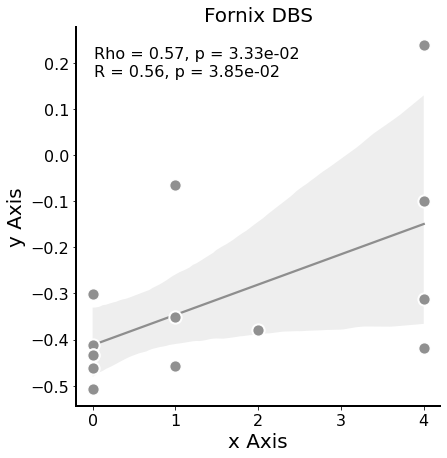

In [327]:
from calvin_utils.statistical_utils.scatterplot import simple_scatter
simple_scatter(data_df, x_col, y_col, 'Fornix DBS', out_dir='/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/ccm_memory/results/notebook_10/scatterplots', flip_axes=True)

# Correlate Variable with All Other Variables

In [325]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


class CorrelationBarPlot:
    """
    Bar-plot SciPy-based Pearson correlations between one column (x_col) and
    every numeric column in a DataFrame, with an optional thresholded view.
    """

    def __init__(self, data_df: pd.DataFrame, x_col: str, method: str = "spearman",
                 figsize=(10, 10), hi_figsize=(20, 20)):
        self.method = method
        self.data_df = data_df
        self.x_col = x_col
        self.figsize = figsize
        self.hi_figsize = hi_figsize

    # ---------- internal helpers ----------
    @staticmethod
    def _clean_pair(a: np.ndarray, b: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        mask = ~np.isnan(a) & ~np.isnan(b)
        return a[mask], b[mask]

    @classmethod
    def _safe_spearman(cls, a: np.ndarray, b: np.ndarray) -> float:
        a, b = cls._clean_pair(a, b)
        if a.size < 2 or np.all(a == a[0]) or np.all(b == b[0]):
            return np.nan
        return stats.spearmanr(a, b)[0]

    @classmethod
    def _safe_pearson(cls, a: np.ndarray, b: np.ndarray) -> float:
        a, b = cls._clean_pair(a, b)
        if a.size < 2 or np.all(a == a[0]) or np.all(b == b[0]):
            return np.nan
        return stats.pearsonr(a, b)[0]

    def _compute_correlations(self) -> pd.Series:
        numeric_df = self.data_df.select_dtypes(include="number")
        if self.method == "spearman":
            corr_func = self._safe_spearman
        elif self.method == "pearson":
            corr_func = self._safe_pearson
        return (
            numeric_df
            .corr(method=corr_func)[self.x_col]
            .sort_values(ascending=False)
        )

    # ---------- public API ----------
    def run(self, save_path: str | None = None, show: bool = True) -> pd.Series:
        """
        Full bar plot of correlations with x_col.
        """
        corr = self._compute_correlations()
        self._plot(corr, self.figsize, save_path, show,
                   title=f"Correlation of {self.x_col} with All Numeric Columns")
        return corr

    def plot_threshold(self, threshold: float = 0.4,
                       save_path: str | None = None, show: bool = True) -> pd.Series:
        """
        Bar plot of correlations whose |r| ≥ threshold (x_col itself excluded).
        """
        corr = self._compute_correlations().drop(self.x_col, errors="ignore")
        filt = corr[corr.abs() >= threshold]
        self._plot(filt, self.hi_figsize, save_path, show,
                   title=f"Correlations with {self.x_col} (|r| ≥ {threshold})")
        return filt

    # ---------- plotting ----------
    def _plot(self, series: pd.Series, figsize, save_path, show, title):
        plt.figure(figsize=figsize, dpi=120)
        series.plot(kind="bar")
        plt.title(title)
        plt.ylabel("R")
        plt.xlabel("Columns")
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, bbox_inches="tight")
        if show:
            plt.show()
        else:
            plt.close()


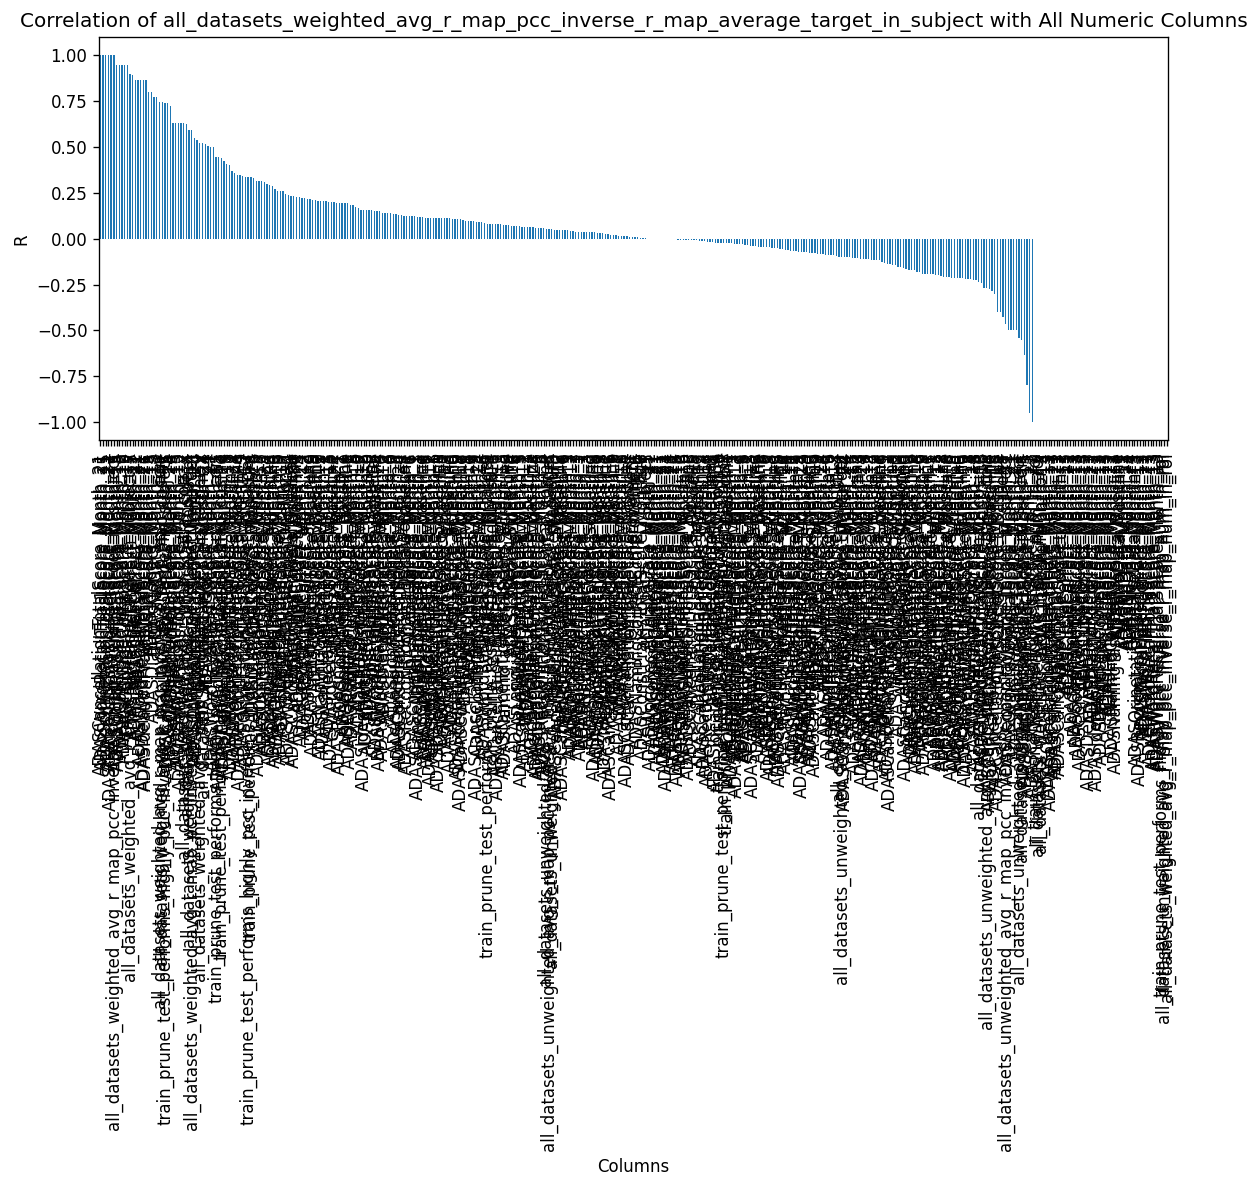

In [155]:
plotter = CorrelationBarPlot(data_df, x_col=x_col, method="spearman")
corr_series = plotter.run(save_path=None)

Focus on correlations above a threhsold

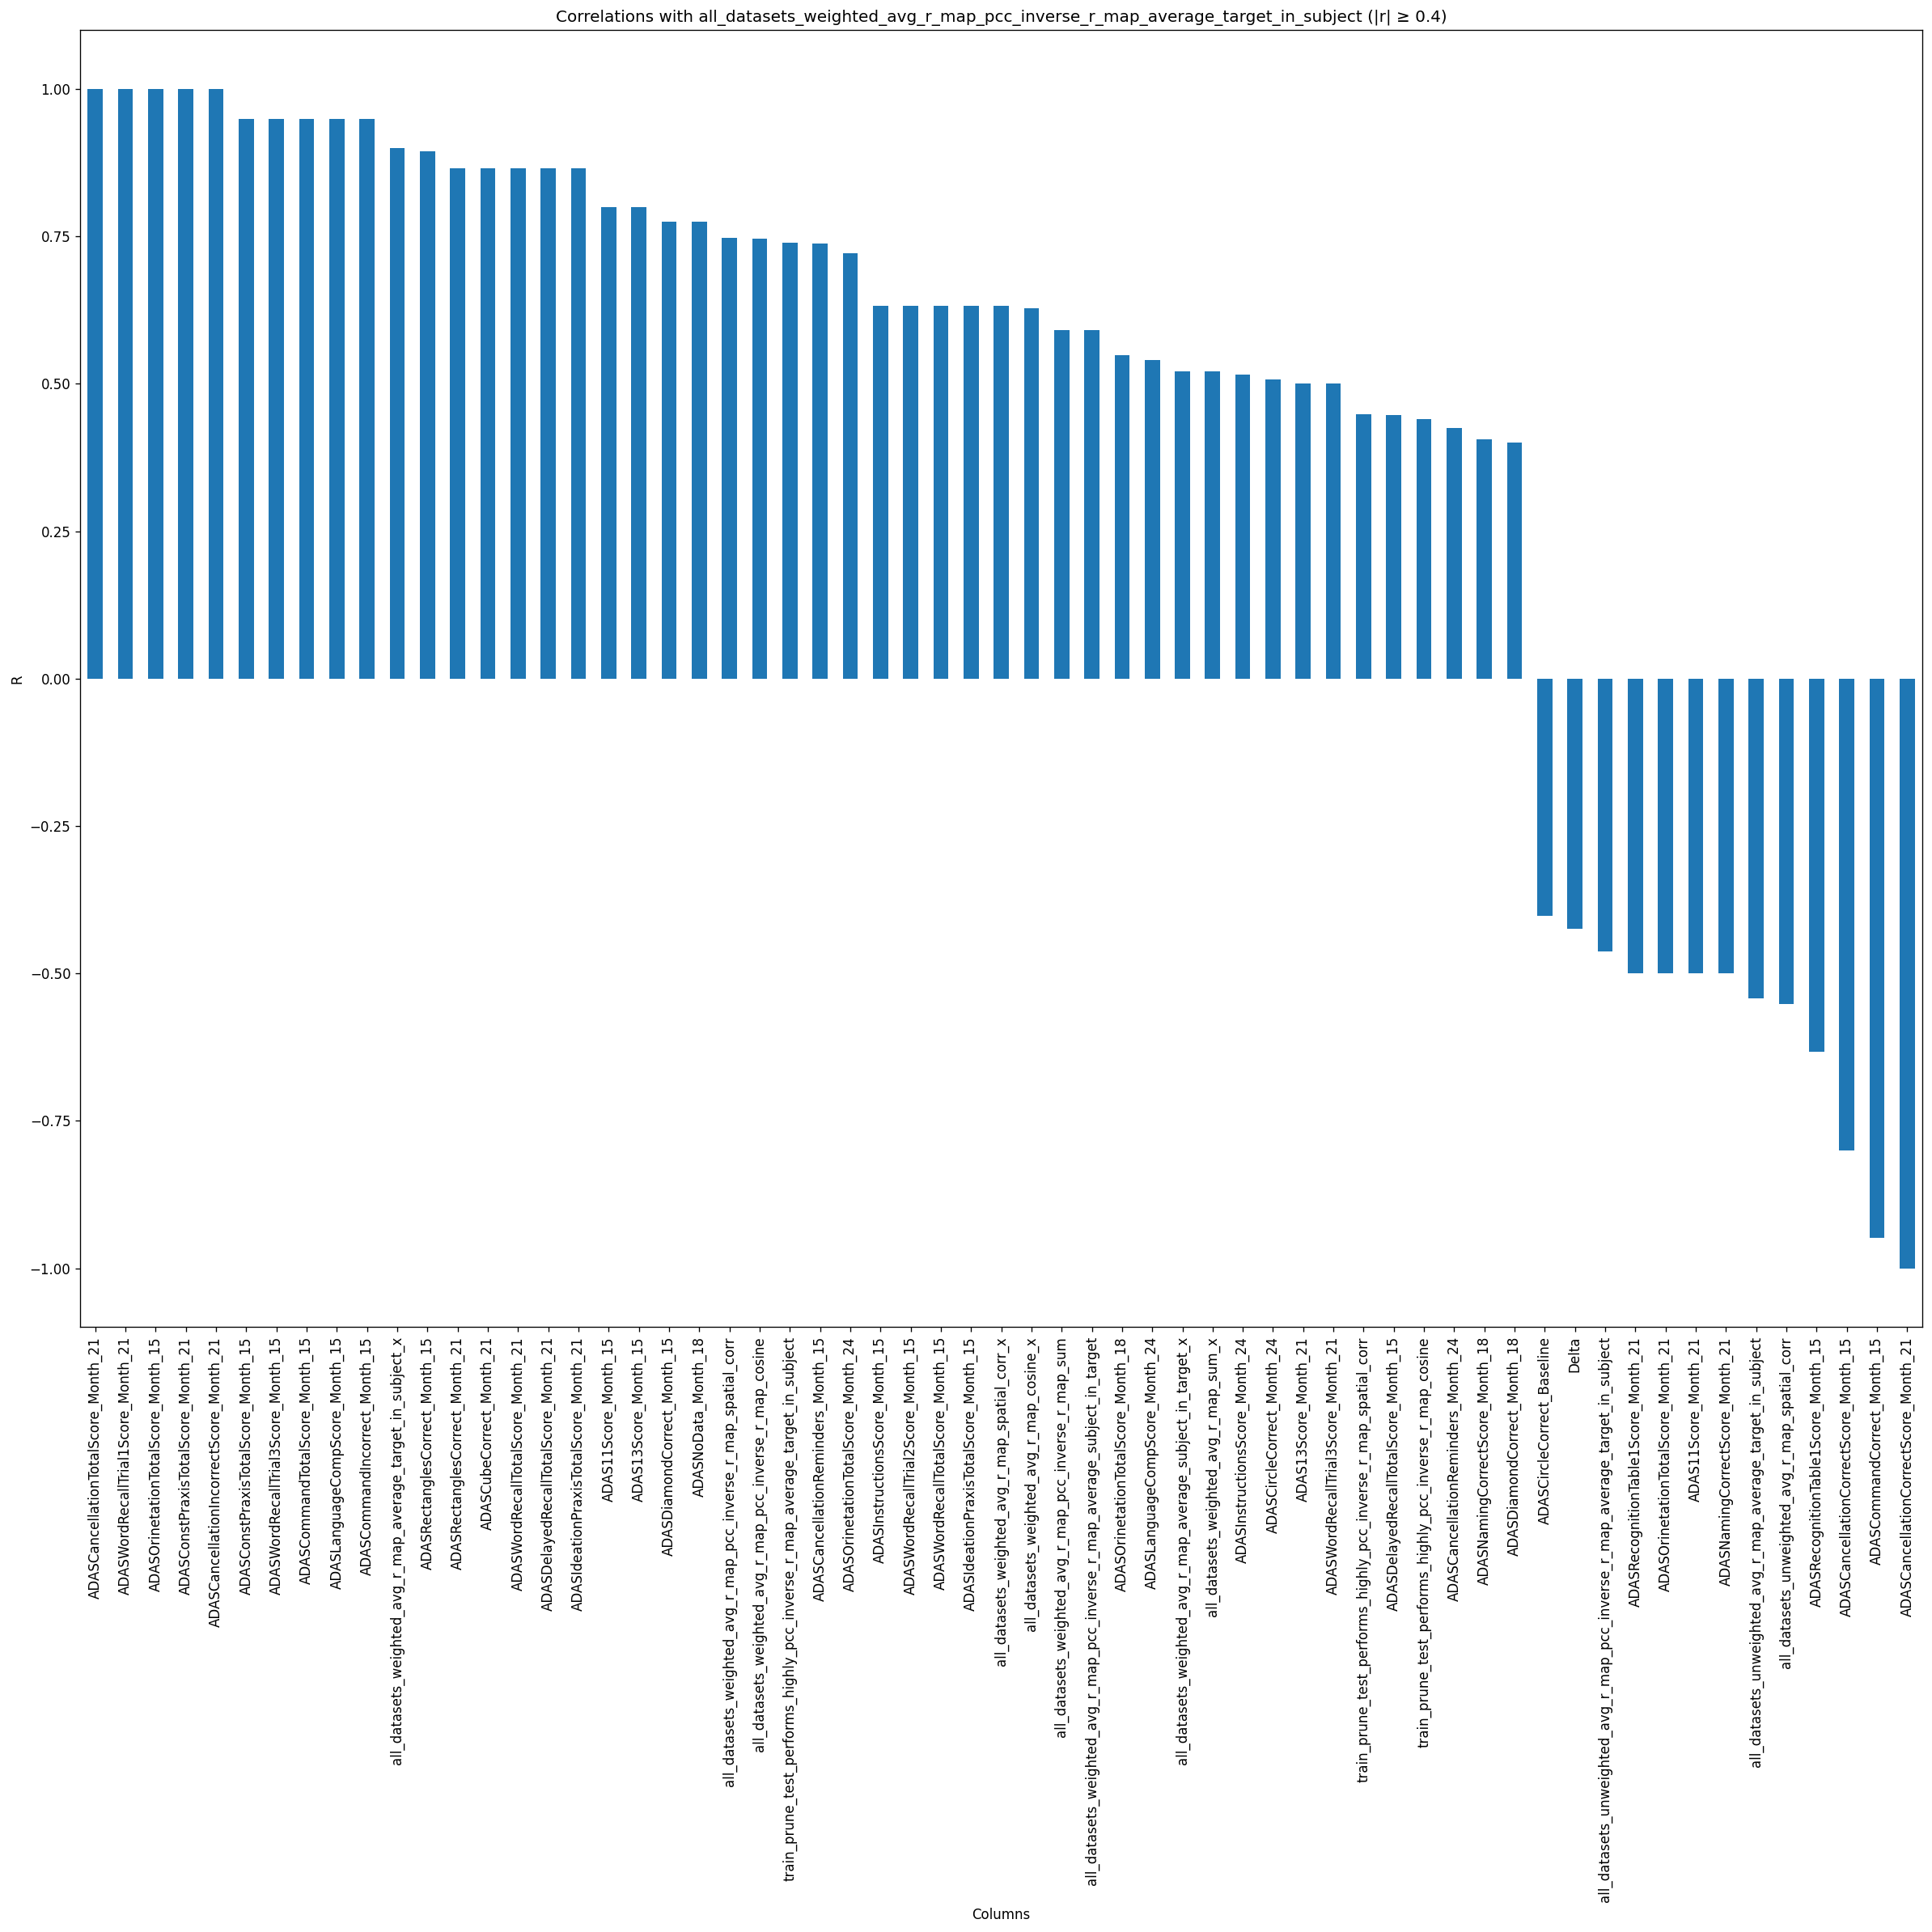

In [157]:
strong_corrs = plotter.plot_threshold(0.4)      # |r| ≥ 0.4 plot